# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/

        
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
# from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# Using Prettytable for displaying the observations
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Vectorizer", "Model", "Hyper Params", "AUC"]
print(table)

+------------+-------+--------------+-----+
| Vectorizer | Model | Hyper Params | AUC |
+------------+-------+--------------+-----+
+------------+-------+--------------+-----+


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score < 3 LIMIT 50000", con)
filtered_data = filtered_data.append(
        pd.read_sql_query("SELECT * FROM Reviews WHERE Score > 3 LIMIT 50000", con))


# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
1,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
2,13,B0009XLVG0,A327PCT23YH90,LT,1,1,0,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, 
                                      ascending=True, inplace=False, 
                                      kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, 
                                  keep='first', inplace=False)
final.shape

(83317, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

83.317

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(83315, 10)


1    45420
0    37895
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.
This stuff tasted so terrible that I had to spit it out before any more of the content permeated my poor mouth. Most people around me wouldn't take up the dare to try one because of the hamster-cage smell drifting out of the bag. The couple people who tried couldn't keep it down. Listen, it's very hard to change your lifestyle, and cookies are more than just food that's bad for you. Cookies make a person feel good, it's true. But if regular cookies have been removed from your menu, try to find something else. Anything else.
These rose buds from Catey13 are precious. They have a soft aroma and a pretty look to them. I plan to use them for small sachets in the bags I bought from catey13, and use rose-colored ribbon to adorn the bags. I'm so glad this seller. I

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.
This stuff tasted so terrible that I had to spit it out before any more of the content permeated my poor mouth. Most people around me wouldn't take up the dare to try one because of the hamster-cage smell drifting out of the bag. The couple people who tried couldn't keep it down. Listen, it's very hard to change your lifestyle, and cookies are more than just food that's bad for you. Cookies make a person feel good, it's true. But if regular cookies have been removed from your menu, try to find something else. Anything else.
These rose buds from Catey13 are precious. They have a soft aroma and a pretty look to them. I plan to use them for small sachets in the bags I bought from catey13, and use rose-colored ribbon to adorn the bags. I'm so glad this seller. I

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

These rose buds from Catey13 are precious. They have a soft aroma and a pretty look to them. I plan to use them for small sachets in the bags I bought from catey13, and use rose-colored ribbon to adorn the bags. I am so glad this seller. I bought several things from her and she gave me a refund on the combined shipping costs.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

These rose buds from Catey13 are precious They have a soft aroma and a pretty look to them I plan to use them for small sachets in the bags I bought from catey13 and use rose colored ribbon to adorn the bags I am so glad this seller I bought several things from her and she gave me a refund on the combined shipping costs 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
review_score = []    # Storing score for later
# tqdm is for printing the status bar
for sentence,score in tqdm(final[['Text', 'Score']].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())
    review_score.append(score)

100%|██████████| 83315/83315 [00:27<00:00, 2984.35it/s]


In [24]:
preprocessed_reviews[1500]

'rose buds precious soft aroma pretty look plan use small sachets bags bought use rose colored ribbon adorn bags glad seller bought several things gave refund combined shipping costs'

In [25]:
len(preprocessed_reviews)

83315

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [26]:
## Similartly you can do preprocessing for review summary also.
preprocessed_summary=[]
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary)
    summary = BeautifulSoup(summary, "lxml").get_text()
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip()
    summary = re.sub('[^A-Za-z]', ' ', summary)
    # https://gist.github.com/sebleier/554280
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    preprocessed_summary.append(summary.strip())

100%|██████████| 83315/83315 [00:16<00:00, 5028.05it/s]


In [27]:
len(preprocessed_summary)

83315

# [4] Featurization

In [26]:
# importing train_test_split to split data for logistic regression

from sklearn.model_selection import train_test_split

In [27]:
# this is random splitting into train, test and cross validation set
ppReview_train, ppReview_test, rs_train, rs_test = train_test_split(preprocessed_reviews, review_score, 
                                                                    test_size=0.30, random_state = 1234) 

## [4.1] BAG OF WORDS

In [28]:
#BoW
count_vect = CountVectorizer(ngram_range=(1,2), min_df=5) #in scikit-learn
count_vect.fit(ppReview_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bow_train = count_vect.transform(ppReview_train)
bow_test = count_vect.transform(ppReview_test)

final_counts = count_vect.transform(ppReview_train)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abc', 'abdomen', 'abdominal', 'abdominal cramping', 'abdominal pain']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (58320, 77859)
the number of unique words  77859


## [4.2] Bi-Grams and n-Grams.

In [23]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect_bi = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect_bi.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (83317, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [29]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tf_idf_vect.fit(ppReview_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

tfIdf_train = tf_idf_vect.transform(ppReview_train)
tfIdf_test = tf_idf_vect.transform(ppReview_test)

final_tf_idf = tf_idf_vect.transform(ppReview_train)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abc', 'abdomen', 'abdominal', 'abdominal cramping', 'abdominal pain']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (58320, 77859)
the number of unique words including both unigrams and bigrams  77859


## [4.4] Word2Vec

In [29]:
# Train your own Word2Vec model using your own text corpus
i=0

# list of sentences divided into train/test and cross validation set
train_sentences = [sentence.split() for sentence in ppReview_train]
test_sentences = [sentence.split() for sentence in ppReview_test]

In [30]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(train_sentences,min_count=5,size=64, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8302961587905884), ('fantastic', 0.7980080842971802), ('perfect', 0.7948470115661621), ('wonderful', 0.7862681746482849), ('terrific', 0.7804150581359863), ('excellent', 0.7771896123886108), ('good', 0.7769888043403625), ('amazing', 0.7267194390296936), ('nice', 0.6586318016052246), ('fabulous', 0.654772162437439)]
[('nastiest', 0.7559326887130737), ('best', 0.7008640766143799), ('disgusting', 0.678912341594696), ('strangest', 0.6501967906951904), ('greatest', 0.6460971236228943), ('weakest', 0.6159319281578064), ('tastiest', 0.593037486076355), ('vile', 0.5840617418289185), ('closest', 0.5646387338638306), ('terrible', 0.5636987090110779)]


In [31]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14929
sample words  ['surprised', 'cookies', 'arrived', 'none', 'smashed', 'crunched', 'perfect', 'treat', 'go', 'cup', 'hot', 'tea', 'cocoa', 'yummy', 'well', 'delivered', 'love', 'lemon', 'honey', 'stirred', 'first', 'thing', 'every', 'morning', 'middle', 'afternoon', 'bigelow', 'english', 'best', 'ever', 'purchased', 'price', 'amazon', 'thank', 'second', 'order', 'pack', 'definitely', 'done', 'flavors', 'great', 'favorites', 'mustard', 'onion', 'jalapeno', 'trio', 'thanks', 'wonderful', 'snack', 'fan']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [32]:
avgW2V_train, avgW2V_test = [], []
c = 0
for i, sent_set in enumerate([train_sentences, test_sentences]):
    for sent in sent_set:
        c += 1
        if c % 1000==0:
            print("Progress : {:3d} %  ".format(int(c/len(preprocessed_reviews)*100)), end='\r')
        sent_vec = np.zeros(64)
        cnt_words = 0
        for word in sent:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        if i==0:
            avgW2V_train.append(sent_vec)
        if i==1:
            avgW2V_test.append(sent_vec)

print("Dims of Train : ({}, {})".format(len(avgW2V_train), len(avgW2V_train[0])))
print("Dims of Test : ({}, {})".format(len(avgW2V_test), len(avgW2V_test[0])))

Dims of Train : (58320, 64)
Dims of Test : (24995, 64)


#### [4.4.1.2] TFIDF weighted W2v

In [33]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(min_df=5)
tf_idf_matrix = model.fit_transform(ppReview_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [34]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf


tfidf_avgW2V_train, tfidf_avgW2V_test = [], []
c = 0
for i, sent_set in enumerate([train_sentences, test_sentences]):
    for sent in sent_set:
        c += 1
        if c % 1000==0:
            print("Progress : {:3d} %  ".format(int(c/len(preprocessed_reviews)*100)), end='\r')
        sent_vec = np.zeros(64)
        weight_sum = 0
        for word in sent:
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        if i==0:
            tfidf_avgW2V_train.append(sent_vec)
        if i==1:
            tfidf_avgW2V_test.append(sent_vec)
            
print("Dims of Train : ({}, {})".format(len(tfidf_avgW2V_train), len(tfidf_avgW2V_train[0])))
print("Dims of Test : ({}, {})".format(len(tfidf_avgW2V_test), len(tfidf_avgW2V_test[0])))

Dims of Train : (58320, 64)
Dims of Test : (24995, 64)


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc \
                , accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.sparse.csr import csr_matrix
import seaborn as sns

In [36]:
def LR_Classifier(X_train, y_train, regOpt):
    cList = np.array([0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, \
                        1, 10, 50, 100, 500, 1000, 5000, 10000])
    params_dict = [{'C': cList}]
    lr_optimal = LogisticRegression(penalty=regOpt)
    
    grid = GridSearchCV(estimator=lr_optimal, 
                        param_grid=params_dict, 
                        scoring='roc_auc', n_jobs=4, cv=5)
    
    grid_result = grid.fit(X_train, y_train)
    train_auc = grid_result.cv_results_['mean_train_score']
    train_auc_std = grid_result.cv_results_['std_train_score']
    cv_auc = grid_result.cv_results_['mean_test_score']
    cv_auc_std = grid_result.cv_results_['std_test_score']
    
    print("Optimal Parameters : ", grid_result.best_estimator_.get_params())
    
    plt.figure(figsize=(10.0, 8.0))
    plt.plot(np.log10(cList), train_auc, label='Train AUC vs C')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(np.log10(cList), train_auc - train_auc_std, 
                          train_auc + train_auc_std, alpha=0.2, color='darkblue')
    
    plt.plot(np.log10(cList), cv_auc, label='CV AUC vs C')
    plt.gca().fill_between(np.log10(cList), cv_auc - cv_auc_std, 
                          cv_auc + cv_auc_std, alpha=0.2, color='darkorange')
    
    plt.title('Area under ROC vs C')
    plt.xlabel('C')
    plt.ylabel('Area')
    plt.legend(loc='lower left')
    plt.show()    

In [51]:
def LR_Classifier_Test(cValue, regOpt, X_train, y_train, X_test, y_test):
    # Setting up the classifier using optimal params

    lr_optimal = LogisticRegression(C=cValue, penalty=regOpt)
    lr_optimal.fit(X_train, y_train)

    # Prediction on training and test set using optimal classifier
    logProb_train = lr_optimal.predict_log_proba(X_train)
    logProb_test = lr_optimal.predict_log_proba(X_test)
    pred_train = np.argmax(logProb_train, axis =1)
    pred_test = np.argmax(logProb_test, axis =1)
    print("Using C value for LR - ", cValue)
    print("Train accuracy for optimal LR ", round(accuracy_score(y_train, pred_train)*100, 2))
    print("Test accuracy for optimal LR ", round(accuracy_score(y_test, pred_test) * 100, 2))

    # ROC-AUC on train & test data
    train_fpr, train_tpr, thresholds = roc_curve(y_train, logProb_train[:, 1], pos_label=1)
    test_fpr, test_tpr, thresholds = roc_curve(y_test, logProb_test[:, 1], pos_label=1)


    # Draw ROC curve
    plt.plot(train_fpr, train_tpr, label="Train AUC = "+str(round(auc(train_fpr, train_tpr), 2)))
    auc_score = round(auc(test_fpr, test_tpr), 2)
    plt.plot(test_fpr, test_tpr, label="Test AUC = "+str(auc_score))
    plt.legend()
    plt.xlabel("False Pos Rate")
    plt.ylabel("True Pos Rate")
    plt.title("ROC Curve of Train and Test")
    plt.show()
    
    return lr_optimal, pred_train, pred_test, auc_score

In [38]:
def draw_Confusion_Matrix(actual, predicted):
    class_label = ["negative", "positive"]
    conf_matrix = confusion_matrix(actual, predicted)
    df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
    hm = sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

Optimal Parameters :  {'C': 0.5, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


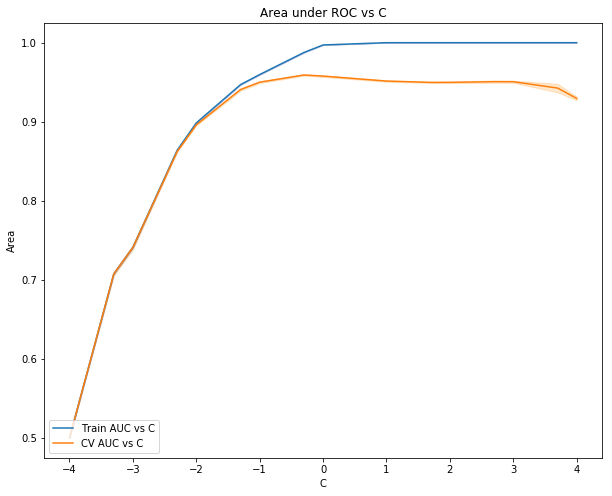

In [39]:
# Please write all the code with proper documentation
regOpt = 'l1'
LR_Classifier(bow_train, rs_train, regOpt)

Using C value for LR -  0.5
Train accuracy for optimal LR  94.67
Test accuracy for optimal LR  90.5


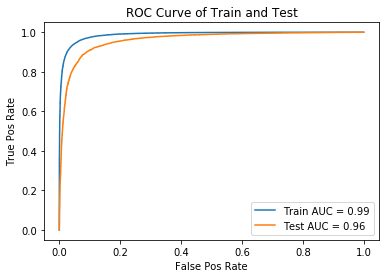

In [52]:
bow_C=0.5
classifier, pred_train, pred_test, auc_score = LR_Classifier_Test(
                                    bow_C, regOpt, bow_train, 
                                    rs_train, bow_test, 
                                    rs_test)

Training Confusion Matrix


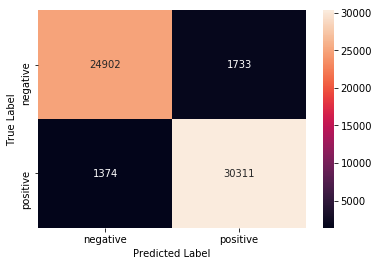




Test Confusion Matrix


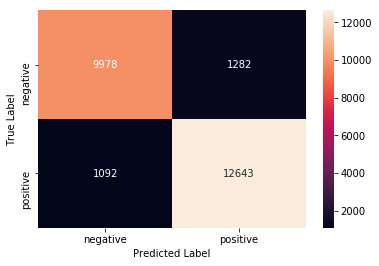

In [53]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["BOW", "Logistic Reg - L1", bow_C, auc_score])

In [54]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89     11260
           1       0.91      0.92      0.91     13735

   micro avg       0.91      0.91      0.91     24995
   macro avg       0.90      0.90      0.90     24995
weighted avg       0.90      0.91      0.90     24995



#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [56]:
# Please write all the code with proper documentation
zero_w = classifier.coef_.size - np.count_nonzero(classifier.coef_)
total_w = classifier.coef_.size
print("Sparsity :  {} %".format(round((zero_w*100)/total_w ,2)))

Sparsity :  93.64 %


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

Optimal Parameters :  {'C': 0.5, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


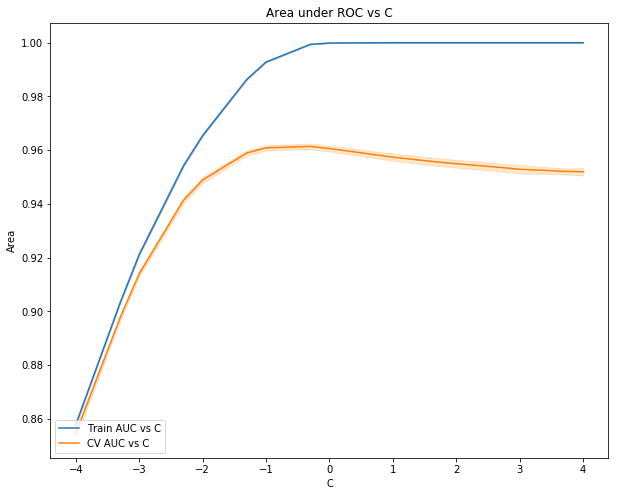

In [57]:
# Please write all the code with proper documentation
regOpt = 'l2'
LR_Classifier(bow_train, rs_train, regOpt)

Using C value for LR -  0.5
Train accuracy for optimal LR  98.9
Test accuracy for optimal LR  90.91


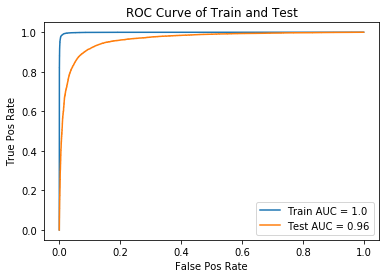

In [150]:
bow_C=0.5
classifier, pred_train, pred_test, auc_score = LR_Classifier_Test(
                                    bow_C, regOpt, bow_train, 
                                    rs_train, bow_test, 
                                    rs_test)

Training Confusion Matrix


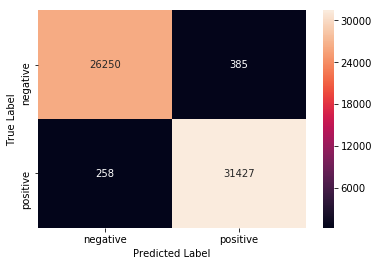




Test Confusion Matrix


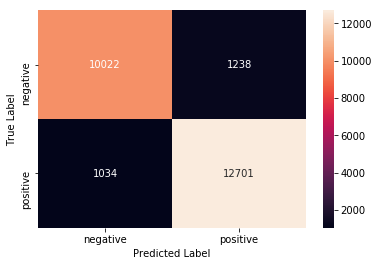

In [59]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["BOW", "Logistic Reg - L2", bow_C, auc_score])

In [60]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90     11260
           1       0.91      0.92      0.92     13735

   micro avg       0.91      0.91      0.91     24995
   macro avg       0.91      0.91      0.91     24995
weighted avg       0.91      0.91      0.91     24995



#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [49]:
# Please write all the code with proper documentation

np.random.seed(0)
# As the second model performs much better so we perform the perturbation 
# test on that, 
lr_clf = LogisticRegression(C=0.5, penalty='l2')
lr_clf.fit(bow_train, rs_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [50]:
bow_train.data

array([1, 1, 1, ..., 1, 1, 1])

In [51]:
# get the weights of the classifier
weights1 = lr_clf.coef_[0] + 0.000001  # to avoid div by zero error

bow_train_ = bow_train.asfptype()
bow_train_.data += np.random.uniform(low=-0.001, high=0.001, 
                            size=(bow_train.data.shape[0],))

In [52]:
lr_clf = LogisticRegression(C=0.5, penalty='l2')
lr_clf.fit(bow_train_, rs_train)
weights2 = lr_clf.coef_[0] + 0.000001  # to avoid div by zero error

In [53]:
# change in weights before and after perturbation
weight_Vec = abs((weights1 - weights2)/weights1)*100

In [54]:
# percentiles of weights_Vec
percentiles = np.percentile(weight_Vec, range(0, 101))

In [55]:
# Checking for spikes, we consider spikes as more than 40% change
# Keeping the threshold to 2.5% gives many outputs(almost whole)
for i in range(1, 101):
    curr = percentiles[i]
    prev = percentiles[i-1]
    change = (abs(curr - prev)/curr)*100
    if change > 40:
        # keeping the threshold to be more than 40% change
        print("Spike at percentile {}".format(i))

Spike at percentile 1
Spike at percentile 2
Spike at percentile 99
Spike at percentile 100


In [56]:
# finding the features where we see spike 
print(weight_Vec[np.where(weight_Vec > 40)].size)

104


In [57]:
# Features which have crossed threshold
print(np.take(count_vect.get_feature_names(), np.where(weight_Vec > 40)))

[['add tiny' 'added fillers' 'almonds chocolate' 'also gives'
  'aspen traditional' 'balance blue' 'bark organic'
  'beautifully designed' 'body lotion' 'brands available' 'bulbs'
  'came taste' 'certainly' 'coffee says' 'comes expiration'
  'commercials cats' 'company not' 'considering great' 'contain omega'
  'containers not' 'cookies small' 'definitely impressed' 'designed info'
  'desperately' 'diet due' 'dog weeks' 'eat paid' 'expensive grocery'
  'fertilizer' 'filtered' 'flavor amazingly' 'flavor brand' 'flavor use'
  'flower tea' 'food puts' 'food suppose' 'found far' 'fresh yogi'
  'full cats' 'get peanut' 'give dog' 'glossary tea' 'got week'
  'great every' 'healthy practices' 'helpful glossary' 'higher'
  'hint cocoa' 'however hard' 'indicates prevalent' 'inexpensive cat'
  'ingredients beautifully' 'ingredients indicates' 'like gummy'
  'like nearly' 'local supermarket' 'lot different' 'maybe would'
  'meats would' 'medicinals values' 'mix two' 'much ginger' 'nt'
  'numi asp

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [160]:
# Please write all the code with proper documentation
print("Top 10 positive features are : ")
print(np.take(count_vect.get_feature_names(), 
              classifier.coef_[0].argsort()[:-11:-1]))

Top 10 positive features are : 
['not disappointed' 'hooked' 'delicious' 'pleased' 'not bitter'
 'excellent' 'yummy' 'not bad' 'perfect' 'amazing']


In [161]:
# Works the same 
print(np.take(count_vect.get_feature_names(), np.argpartition(
                        classifier.coef_[0], -10)[-10:]))

['amazing' 'pleased' 'excellent' 'not bad' 'perfect' 'yummy' 'not bitter'
 'hooked' 'delicious' 'not disappointed']


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [162]:
# Please write all the code with proper documentation
print("Top 10 Negative features are : ")
print(np.take(count_vect.get_feature_names(), 
              (-classifier.coef_[0]).argsort()[:-11:-1]))

Top 10 Negative features are : 
['not worth' 'disappointing' 'worst' 'terrible' 'two stars' 'disappointed'
 'not recommend' 'awful' 'disappointment' 'not good']


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

Optimal Parameters :  {'C': 10.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


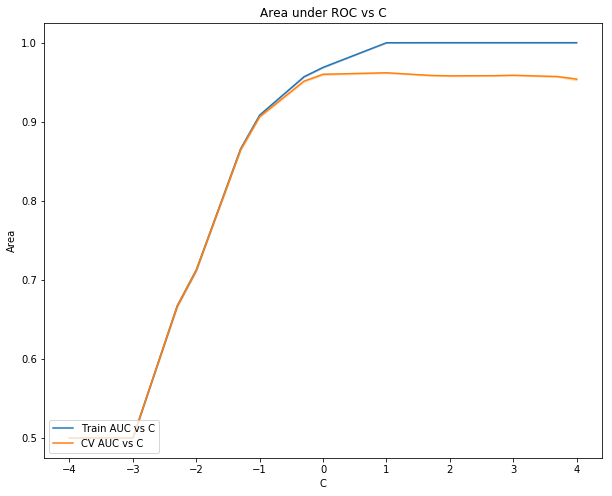

In [164]:
# Please write all the code with proper documentation
regOpt = 'l1'
LR_Classifier(tfIdf_train, rs_train, regOpt)

Using C value for LR -  10.0
Train accuracy for optimal LR  99.72
Test accuracy for optimal LR  90.13


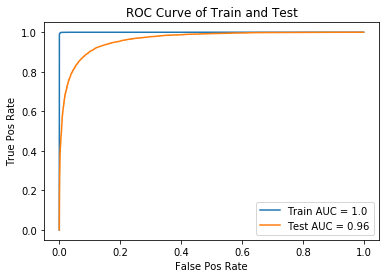

In [165]:
tfIdf_C=10.0
classifier, pred_train, pred_test, auc_score = LR_Classifier_Test(
                                    tfIdf_C, regOpt, tfIdf_train, 
                                    rs_train, tfIdf_test, 
                                    rs_test)

Training Confusion Matrix


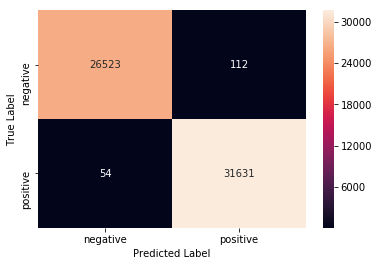




Test Confusion Matrix


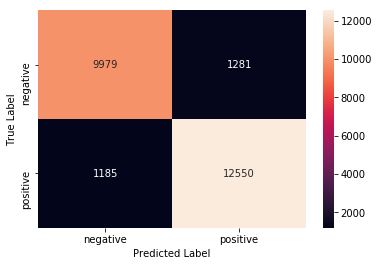

In [167]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["Tf-Idf", "Logistic Reg - L1", tfIdf_C, auc_score])

In [168]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     11260
           1       0.91      0.91      0.91     13735

   micro avg       0.90      0.90      0.90     24995
   macro avg       0.90      0.90      0.90     24995
weighted avg       0.90      0.90      0.90     24995



### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

Optimal Parameters :  {'C': 10.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


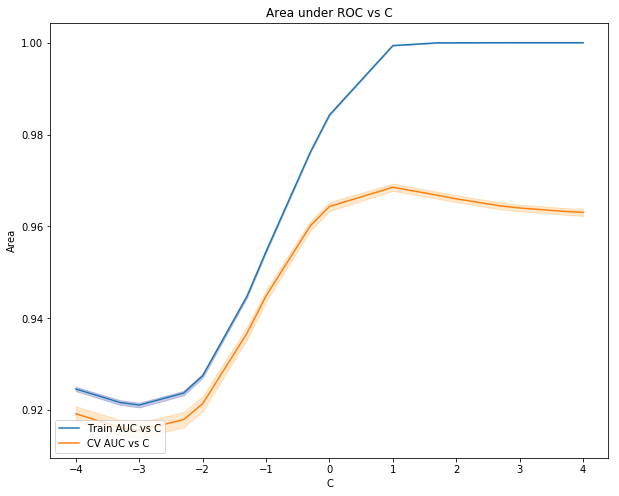

In [169]:
# Please write all the code with proper documentation
regOpt = 'l2'
LR_Classifier(tfIdf_train, rs_train, regOpt)

Using C value for LR -  10.0
Train accuracy for optimal LR  98.88
Test accuracy for optimal LR  91.13


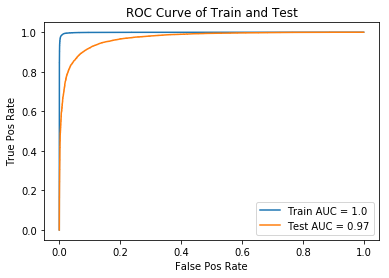

In [385]:
tfIdf_C=10.0
classifier, pred_train, pred_test, auc_score = LR_Classifier_Test(
                                    tfIdf_C, regOpt, tfIdf_train, 
                                    rs_train, tfIdf_test, 
                                    rs_test)

Training Confusion Matrix


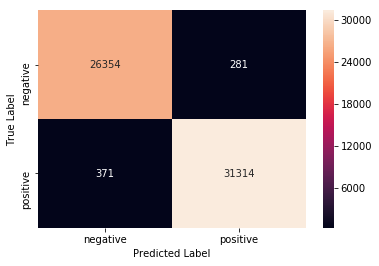




Test Confusion Matrix


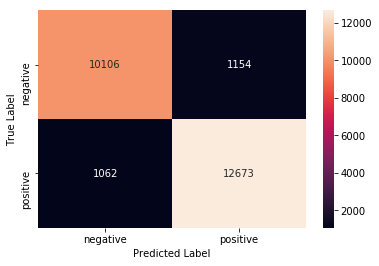

In [171]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["Tf-Idf", "Logistic Reg - L2", tfIdf_C, auc_score])

In [172]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     11260
           1       0.92      0.92      0.92     13735

   micro avg       0.91      0.91      0.91     24995
   macro avg       0.91      0.91      0.91     24995
weighted avg       0.91      0.91      0.91     24995



### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [386]:
# Please write all the code with proper documentation
print("Top 10 positive features are : ")
print(np.take(tf_idf_vect.get_feature_names(), 
              classifier.coef_[0].argsort()[:-11:-1]))

Top 10 positive features are : 
['great' 'delicious' 'not disappointed' 'best' 'good' 'perfect'
 'excellent' 'loves' 'wonderful' 'pleased']


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [387]:
# Please write all the code with proper documentation
print("Top 10 negative features are : ")
print(np.take(tf_idf_vect.get_feature_names(), 
              (-classifier.coef_[0]).argsort()[:-11:-1]))

Top 10 negative features are : 
['disappointed' 'worst' 'terrible' 'disappointing' 'not worth' 'awful'
 'not good' 'not recommend' 'not' 'disappointment']


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

Optimal Parameters :  {'C': 100.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


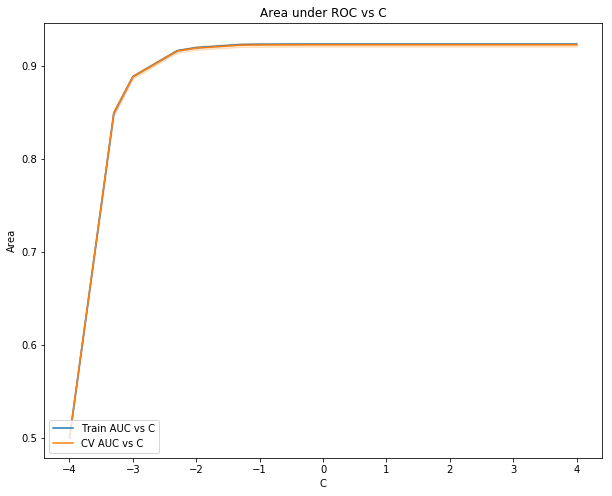

In [176]:
# Please write all the code with proper documentation
regOpt = 'l1'
LR_Classifier(avgW2V_train, rs_train, regOpt)

Using C value for LR -  100.0
Train accuracy for optimal LR  84.74
Test accuracy for optimal LR  84.49


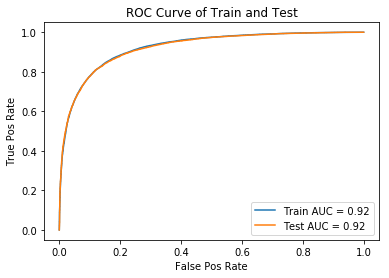

In [177]:
avgW2V_C=100.0
classifier, pred_train, pred_test, auc_score = LR_Classifier_Test(
                                    avgW2V_C, regOpt, avgW2V_train, 
                                    rs_train, avgW2V_test, 
                                    rs_test)

Training Confusion Matrix


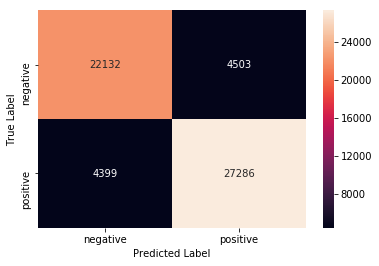




Test Confusion Matrix


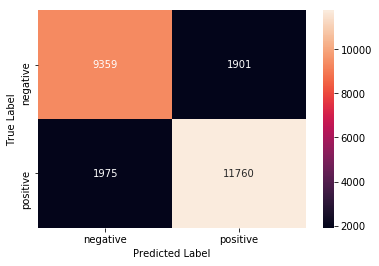

In [178]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["Avg W2V", "Logistic Reg - L1", avgW2V_C, auc_score])

In [179]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83     11260
           1       0.86      0.86      0.86     13735

   micro avg       0.84      0.84      0.84     24995
   macro avg       0.84      0.84      0.84     24995
weighted avg       0.85      0.84      0.84     24995



### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

Optimal Parameters :  {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


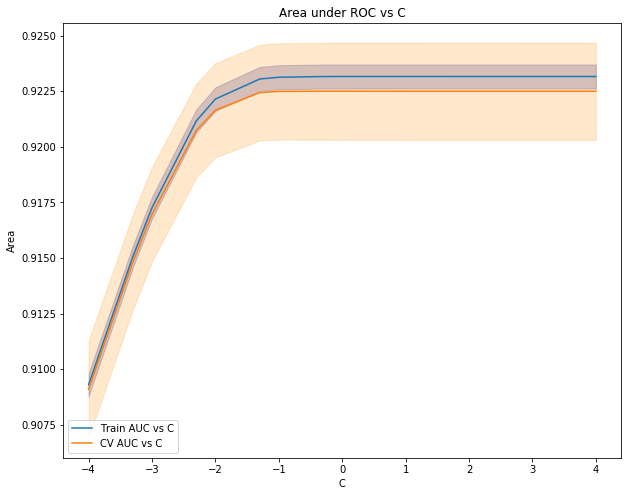

In [180]:
# Please write all the code with proper documentation
regOpt = 'l2'
LR_Classifier(avgW2V_train, rs_train, regOpt)

Using C value for LR -  1.0
Train accuracy for optimal LR  84.73
Test accuracy for optimal LR  84.5


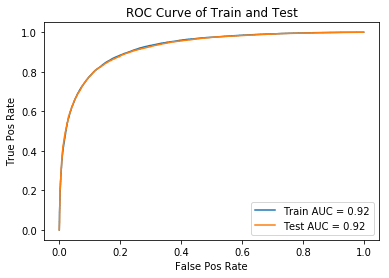

In [181]:
avgW2V_C=1.0
classifier, pred_train, pred_test, auc_score = LR_Classifier_Test(
                                    avgW2V_C, regOpt, avgW2V_train, 
                                    rs_train, avgW2V_test, 
                                    rs_test)

Training Confusion Matrix


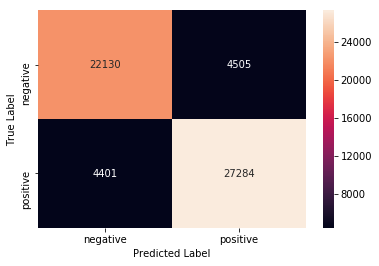




Test Confusion Matrix


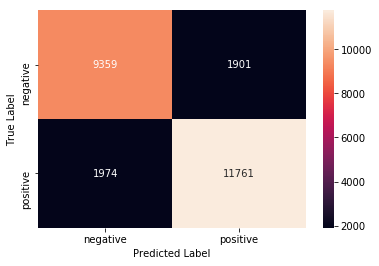

In [182]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["Avg W2V", "Logistic Reg - L2", avgW2V_C, auc_score])

In [183]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83     11260
           1       0.86      0.86      0.86     13735

   micro avg       0.84      0.84      0.84     24995
   macro avg       0.84      0.84      0.84     24995
weighted avg       0.85      0.84      0.85     24995



## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

Optimal Parameters :  {'C': 5000.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


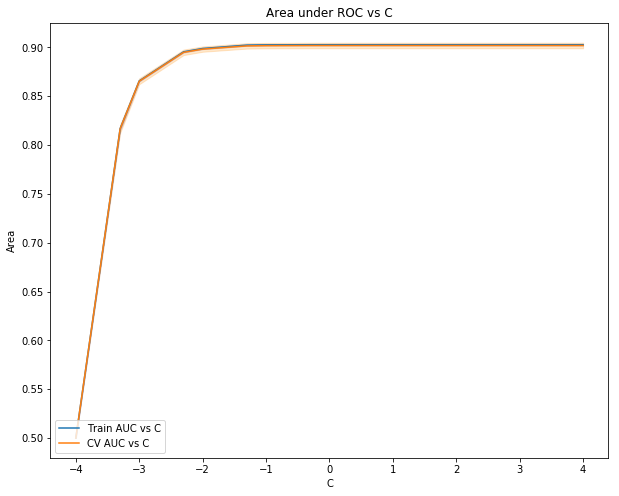

In [184]:
# Please write all the code with proper documentation
regOpt = 'l1'
LR_Classifier(tfidf_avgW2V_train, rs_train, regOpt)

Using C value for LR -  5000.0
Train accuracy for optimal LR  82.36
Test accuracy for optimal LR  82.2


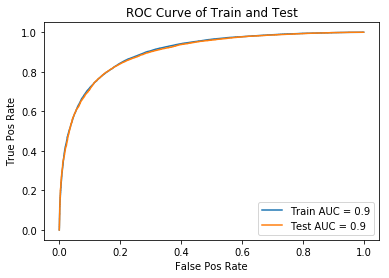

In [185]:
tfIdf_avgW2V_C=5000.0
classifier, pred_train, pred_test, auc_score = LR_Classifier_Test(
                                    tfIdf_avgW2V_C, regOpt, tfidf_avgW2V_train, 
                                    rs_train, tfidf_avgW2V_test, 
                                    rs_test)

Training Confusion Matrix


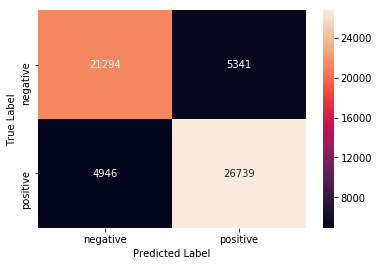




Test Confusion Matrix


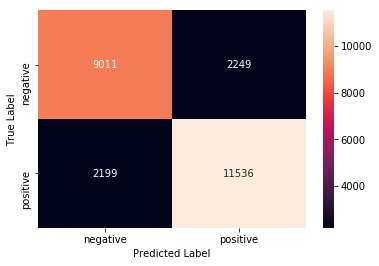

In [186]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["Tf-Idf Avg W2V", "Logistic Reg - L1", tfIdf_avgW2V_C, auc_score])

In [187]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80     11260
           1       0.84      0.84      0.84     13735

   micro avg       0.82      0.82      0.82     24995
   macro avg       0.82      0.82      0.82     24995
weighted avg       0.82      0.82      0.82     24995



### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

Optimal Parameters :  {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


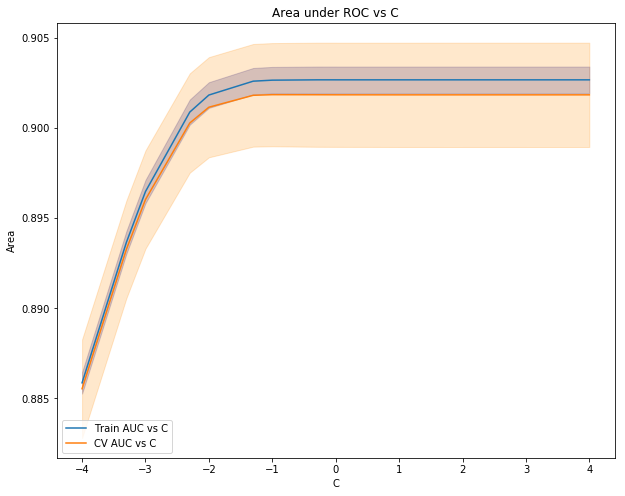

In [188]:
# Please write all the code with proper documentation
regOpt = 'l2'
LR_Classifier(tfidf_avgW2V_train, rs_train, regOpt)

Using C value for LR -  0.1
Train accuracy for optimal LR  82.34
Test accuracy for optimal LR  82.21


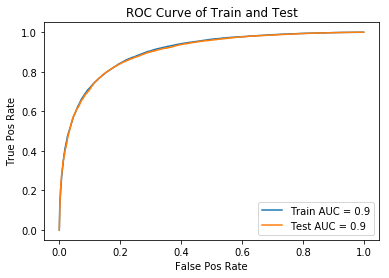

In [189]:
tfIdf_avgW2V_C=0.1
classifier, pred_train, pred_test, auc_score = LR_Classifier_Test(
                                    tfIdf_avgW2V_C, regOpt, tfidf_avgW2V_train, 
                                    rs_train, tfidf_avgW2V_test, 
                                    rs_test)

Training Confusion Matrix


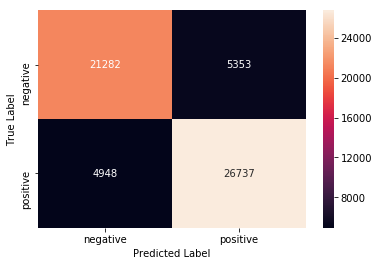




Test Confusion Matrix


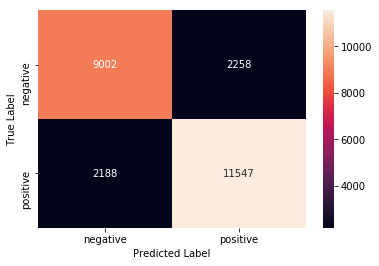

In [190]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["Tf-Idf Avg W2V", "Logistic Reg - L2", tfIdf_avgW2V_C, auc_score])

In [191]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80     11260
           1       0.84      0.84      0.84     13735

   micro avg       0.82      0.82      0.82     24995
   macro avg       0.82      0.82      0.82     24995
weighted avg       0.82      0.82      0.82     24995



# [6] Conclusions

In [192]:
# Please compare all your models using Prettytable library
print(table)

+----------------+-------------------+--------------+------+
|   Vectorizer   |       Model       | Hyper Params | AUC  |
+----------------+-------------------+--------------+------+
|      BOW       | Logistic Reg - L1 |     0.5      | 0.96 |
|      BOW       | Logistic Reg - L2 |     0.5      | 0.96 |
|     Tf-Idf     | Logistic Reg - L1 |     10.0     | 0.96 |
|     Tf-Idf     | Logistic Reg - L2 |     10.0     | 0.97 |
|    Avg W2V     | Logistic Reg - L1 |    100.0     | 0.92 |
|    Avg W2V     | Logistic Reg - L2 |     1.0      | 0.92 |
| Tf-Idf Avg W2V | Logistic Reg - L1 |    5000.0    | 0.9  |
| Tf-Idf Avg W2V | Logistic Reg - L2 |     0.1      | 0.9  |
+----------------+-------------------+--------------+------+


 - For BOW Vectors
     - Clearly the L2 regularised logistic regression classifier prooves to be <br>
         slightly better having same test AUC of 0.96 but slightly better train AUC score<br>
     - Also the f1 score for l2 classifier improves with a score 0.01<br>
     - The C values for both l1 and l2 remain same<br>
     - Sparsity percentage of 93.6 % shows the vectors are highly sparsed<br>
     - The top 10 positive and negative features are highly interpretable compared to <br>
         naive bayes classification results
     
     
 - For Tf-Idf Vectors
     - The C value jumps from 0.5 to 10.0
     - Although the f1 score remains same compared to bow Vectors but the accuracy<br>
         has improved slightly
     - Again between the L1 and L2 classifiers, the L2 takes a slight edge over L1
     - The top 10 positive and negative features are highly interpretable, same as before.
 
 
 - For Average Word2Vec
     - We see a drastic difference between the C values, while the optimal C for L1 <br>
         classifier is 100, for l2 is drastically reduces to 1.0
     - There is a significant decrease in the model accuracy, AUC and F1 scores showing a<br>
         less powerful model compared to Tf-Idf and bow vectors
     - Inspite of immense difference in C values, both l1 and l2 perform almost similarly.
 
 
 - For TfIdf Weighted Word2Vec
     - We see a more drastic difference in the C values for l1 and l2 regularisers, l1 being <br>
         5000 and l2 being 0.1
     - The classifier performance and the evaluation further degrade even compared with Average<br>
         word2Vec
  
  - Probably the numbers of dimensions(64) is not catching enough context for proper classification<br>
      compared to the bow and tf-idf having huge dimensions
     